# Action Recognition @ UCF101  
**Due date: 11:59 pm on Dec. 19, 2017 (Tuesday)**

## Description
---
In this semi-project, you will be doing action recognition using Recurrent Neural Network (RNN), (Long-Short Term Memory) LSTM in particular. You will be given a dataset called UCF101, which consists of 101 different actions/classes and for each action, there will be 145 samples. We tagged each sample into either training or testing. Each sample is supposed to be a short video, but we sampled 25 frames from each videos to reduce the data amount. Consequently, a training sample is a tuple of 3D volume with one dimension encoding *temporal correlation* between frames and a label indicating what action it is.

To tackle this problem, we aim to build a neural network that can not only capture spatial information of each frame but also temporal information between frames. Fortunately, you don't have to do this on your own. RNN — a type of neural network designed to deal with time-series data — is right here for you to use. In particular, you will be using LSTM for this task.

Instead of training a end-to-end neural network from scratch whose computation is prohibitively expensive for CPUs. We divide this into two steps: feature extraction and modelling. Below are the things you need to implement for this semi-homework:
- **{40 pts} Feature extraction**. Use the pretrained VGG network to extract features from each frame. Specifically, we recommend  to use the activations of the first fully connected layer `torchvision.models.vgg16` (4096 dim) as features of each video frame. This will result into a 4096x25 matrix for each video. 
    **hints**: 
    - use `scipy.io.savemat()` to save feature to '.mat' file and `scipy.io.loadmat()` load feature.
    - norm your images using `torchvision.transforms`
    ```
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    prep = transforms.Compose([ transforms.ToTensor(), normalize ])
    prep(img)
    
    ```
    More detils of image preprocessing in PyTorch can be found at http://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    
- **{40 pts} Modelling**. With the extracted features, build an LSTM network which takes a 4096x25 sample as input, and outputs the action label of that sample.
- **{20 pts} Evaluation**. After training your network, you need to evaluate your model with the testing data by computing the prediction accuracy. Moreover, you need to compare the result of your network with that of support vector machine (SVM) (stacking the 4096x25 feature matrix to a long vector and train a SVM).

Notice that the size of the raw images is 256x340, whereas VGG16 takes 224x224 images as inputs. To solve this problem, instead of resizing the images which unfavorably changes the spatial ratio, we take a better solution: Cropping five 224x224 images at the image center and four corners and compute the 4096-dim VGG16 features for each of them, and average these five 4096-dim feature to get final feature representation for the raw image.

In order to save your computational time, we did the feature extraction of most samples for you except for class 1. For class 1, we provide you with the raw images, and you need to write code to extract the feature of the samples in class 1. Besides, instead of training over the whole dataset on CPUs which mays cost you serval days, you could just use the first 10 or 20 classes of the whole dataset. But for those who have access to GPUs, you can try more classes or even the whole dataset.


## Dataset
Download dataset at [UCF101](http://vision.cs.stonybrook.edu/~yangwang/public/UCF101_dimitris_course.zip). 

The dataset is consist of the following two parts: video images and extracted features.

### 1. Video Images  

UCF101 dataset contains 101 actions and 13,320 videos in total.  

+ `annos/actions.txt`  
  + lists all the actions (`ApplyEyeMakeup`, .., `YoYo`)   
  
+ `annots/videos_labels_subsets.txt`  
  + lists all the videos (`v_000001`, .., `v_013320`)  
  + labels (`1`, .., `101`)  
  + subsets (`1` for train, `2` for test)  

+ `images_class1/`  
  + contains videos belonging to class 1 (`ApplyEyeMakeup`)  
  + each video folder contains 25 frames  


### 2. Video Features

+ `extract_vgg16_relu6.py`  
  + used to extract video features  
     + Given an image (size: 256x340), we get 5 crops (size: 224x224) at the image center and four corners. The `vgg16-relu6` features are extracted for all 5 crops and subsequently averaged to form a single feature vector (size: 4096).  
     + Given a video, we process its 25 images seuqentially. In the end, each video is represented as a feature sequence (size: 4096 x 25).  
  + written in PyTorch; supports both CPU and GPU.  

+ `vgg16_relu6/`  
   + contains all the video features, EXCEPT those belonging to class 1 (`ApplyEyeMakeup`)  
   + you need to run script `extract_vgg16_relu6.py` to complete the feature extracting process   


## Some Tutorials
- Good materials for understanding RNN and LSTM
    - http://blog.echen.me
    - http://karpathy.github.io/2015/05/21/rnn-effectiveness/
    - http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Implementing RNN and LSTM with PyTorch
    - [LSTM with PyTorch](http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py)
    - [RNN with PyTorch](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [62]:
# write your code here
# import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import os
import scipy
import sklearn


import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.optim import lr_scheduler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from PIL import Image
from scipy import io
from sklearn import svm

import time
print ('OpenCV version = ' + cv2.__version__)

OpenCV version = 3.3.0


In [63]:
# just something for the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm) # uncomment if you want to print like normal data
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
# function to just plot both normalizes and normal matrix

def print_confusion_matrix(test_label, predictions, index):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_label, predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_matrix,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_matrix, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [65]:
# function to parse the actions.txt file to get the name of all actions
# function to parse the file whose filename is passed
# return type: data set of all the class names
def get_action_classes(fileName):
    File = str(fileName)
    row = []
    category = []
    with open(File) as inFile: #opening the file to scrap data
        for line in inFile: #separating each line
            items = line.strip().split(',') #splits the string into an array
            for each in items:
                record = each.strip().split('  ')
                category.append(record[1])
    return category

In [66]:
# function to parse the videos_labels_subsets.txt file 
# to get all the labels associated with each set of video representation
#function to parse the file whose filename is passed
#return type: train,train_labels, test, test_labels
def get_video_labels(fileName):
    File = str(fileName)
    row = []
    category = []
    with open(File) as inFile: #opening the file to scrap data
        for line in inFile: #separating each line
            items = line.strip().split(',') #splits the string into an array
            for each in items:
                record = each.strip().split('\t')
                row.append(record)
    return seperate_data(row) # return data set

In [67]:
# a helper function for get_video_labels(filename)
# gets the labels and tag associated with each video 
# and divides them into test and training data names and labels
#return type: train,train_labels, test, test_labels
def seperate_data(label_names):
    train = []
    test = []
    train_labels = []
    test_labels = []
    for item in label_names:
        if (item[2]=='1'):
            train.append(item[0])
            train_labels.append(int(item[1]))
        else:
            test.append(item[0])
            test_labels.append(int(item[1]))
    return train, train_labels, test, test_labels

In [68]:
# defining the path for each extraction
annotations = 'UCF101_release/annos/actions.txt'
video_annotations = 'UCF101_release/annos/videos_labels_subsets.txt'

In [69]:
class_names_all = get_action_classes(annotations) #get all action names
class_names = dict(zip(range(1, len(class_names_all)+1), class_names_all))
# change it into a dictionary for each access

print("The visual system is made to recognise the following tasks:")
for x in class_names:
    print(x,'. ', class_names[x])

# get all labels and name of training and test data features
train, train_labels, test, test_labels = get_video_labels(video_annotations)

The visual system is made to recognise the following tasks:
(1, '. ', 'ApplyEyeMakeup')
(2, '. ', 'ApplyLipstick')
(3, '. ', 'Archery')
(4, '. ', 'BabyCrawling')
(5, '. ', 'BalanceBeam')
(6, '. ', 'BandMarching')
(7, '. ', 'BaseballPitch')
(8, '. ', 'Basketball')
(9, '. ', 'BasketballDunk')
(10, '. ', 'BenchPress')
(11, '. ', 'Biking')
(12, '. ', 'Billiards')
(13, '. ', 'BlowDryHair')
(14, '. ', 'BlowingCandles')
(15, '. ', 'BodyWeightSquats')
(16, '. ', 'Bowling')
(17, '. ', 'BoxingPunchingBag')
(18, '. ', 'BoxingSpeedBag')
(19, '. ', 'BreastStroke')
(20, '. ', 'BrushingTeeth')
(21, '. ', 'CleanAndJerk')
(22, '. ', 'CliffDiving')
(23, '. ', 'CricketBowling')
(24, '. ', 'CricketShot')
(25, '. ', 'CuttingInKitchen')
(26, '. ', 'Diving')
(27, '. ', 'Drumming')
(28, '. ', 'Fencing')
(29, '. ', 'FieldHockeyPenalty')
(30, '. ', 'FloorGymnastics')
(31, '. ', 'FrisbeeCatch')
(32, '. ', 'FrontCrawl')
(33, '. ', 'GolfSwing')
(34, '. ', 'Haircut')
(35, '. ', 'Hammering')
(36, '. ', 'HammerThrow'

In [70]:
print("In total, we would have", len(train)+len(test), "number of feature representation.")
print("The size of the training set is",len(train_labels),".")
print("The size of the test set is",len(test_labels),".")
print("The number of classes in the dataset is", len(class_names),".")

('In total, we would have', 13320, 'number of feature representation.')
('The size of the training set is', 9537, '.')
('The size of the test set is', 3783, '.')
('The number of classes in the dataset is', 101, '.')


In [71]:
# function to show a passed image
def imshow(img):
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()

In [72]:
# function which returns a list of cropped images for a passed image
# works with images passed as normal numpy array or a tensor
# passed argument: image itself, what size you want the crops to be
# returns only a list of numpy cropped images
# uncomment to change into tensors for tensors
def get_five_crops(img, size):
    s_h, s_w = size
    crop = []
    is_tensor = torch.is_tensor(img)
    # change into a numpy array properly if it is tensor
    # Tensor image's shape -> channels*height*width
    # Numpy image's shape -> height*width*channels
    if (is_tensor):
        temp = img.numpy()
        temp = np.transpose(temp, [1, 2, 0])
        img = temp
        
    height, width, color = img.shape
    crop.append(img[0:s_h, 0:s_w]) #image 1
    crop.append(img[0:s_h, (width-s_w):width]) #image 2
    crop.append(img[(height-s_h):height, 0:s_w]) #image 3
    crop.append(img[(height-s_h):height, (width-s_w):width]) #image 4
    mid_y = int(height/2 - s_h/2)
    mid_x = int(width/2 - s_w/2)
    crop.append(img[mid_y:(mid_y + s_h), mid_x:(mid_x + s_w)]) # image 5 # center

#     uncomment to change into tensors for tensors
#     if (is_tensor):
#         for i, each in enumerate(crop):
#             crop[i] = torch.from_numpy(each.transpose(2,0,1))
    return crop

In [73]:
# function to normalize a given image
# returns normalized tensors
def img_norm(img):
    #norm the images
    size = (224,224)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    prep = transforms.Compose([ transforms.ToTensor(), normalize ])
    return prep(img) #to prepare the image

In [74]:
# function which prepares the image
# first normalizes
# then extracts the 5 crops of the normalized pictures
# and returns it as a list
def prep_img(img, img_size):
    return (get_five_crops(img_norm(img), img_size))

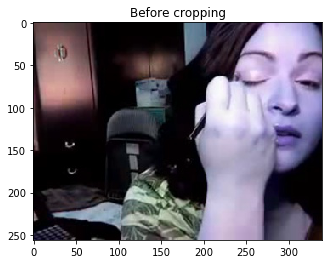

In [75]:
img = cv2.imread('UCF101_release/images_class1/v_000001/i_0001.jpg')
plt.figure()
plt.title('Before cropping')
plt.imshow(img, 'gray')
plt.show()

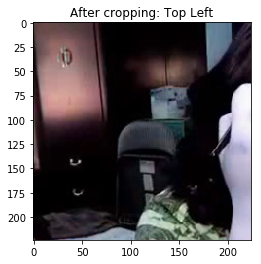

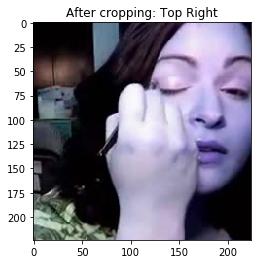

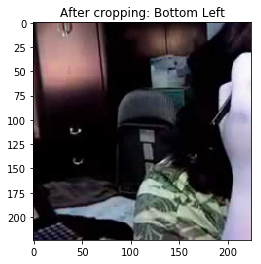

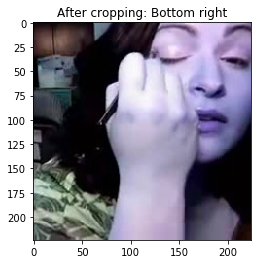

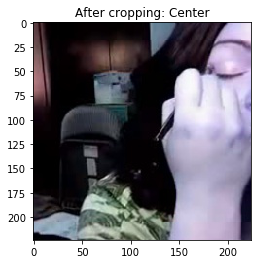

In [76]:
img_size = (224, 224)
img = cv2.imread('UCF101_release/images_class1/v_000001/i_0001.jpg')
arr = ['Top Left', 'Top Right', 'Bottom Left', 'Bottom right', 'Center']
for i, img1 in enumerate(get_five_crops(img, img_size)):
    plt.figure()
    plt.title('After cropping: ' + arr[i])
    plt.imshow(img1, 'gray')
    plt.show()

In [77]:
# extracts the name of all videos for image set 1
# here 29 just represents the length of 'UCF101_release/images_class1/'
# as we need to skip that to get to the actual name of the video
vid_names = [name[29:] for name in glob.glob('UCF101_release/images_class1/*')]
vid_names = dict(zip(range(len(vid_names)), vid_names))

# ==============================================================
#    Load Data for Feature Extraction #Both Train and Test Data
# ==============================================================

def load_dataset(path, img_size, batch_num=1, is_color=False):
    data = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
    
    # read images and resizing
    for id, vid_name in vid_names.items():
        img_path_class = glob.glob(path + vid_name + '/*.jpg')
        for filename in img_path_class:
            img = cv2.imread(filename) # read the file
            crops = prep_img(img, img_size) # prepare the image
            for each in crops: # change each picture into channels*height*width
                data.append(np.transpose(each, [2, 0, 1]))
                
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        for i in range(int(len(data) / batch_num)):
            minibatch_d = np.array(data[i*batch_num: (i+1)*batch_num])
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
        data = batch_data
        
    return data

In [78]:
s = time.clock()
img_size = (224, 224)
batch_num = 5 # samples number per batch 

# load dataset for feature extraction
class1_data = load_dataset('UCF101_release/images_class1/', img_size, batch_num=batch_num, is_color=True)
class1_num = len(class1_data)
print ("Finish loading %d minibatches(=%d) of class 1 samples." % (class1_num, batch_num))
e = time.clock()

print("Time Taken: ", int((e-s)//60), "min and", float((e-s)%60),"sec")

Finish loading 3625 minibatches(=5) of class 1 samples.
('Time Taken: ', 0, 'min and', 36.85550999999998, 'sec')


In [79]:
print ("The dimension of the loaded dataset is " + str(len(class1_data)) + "*"  + str(len(class1_data[0])) + "*" + str(len(class1_data[0][0])) + "*" + str(len(class1_data[0][0][0])) + "*" + str(len(class1_data[0][0][0][0])))
#3625*5*3*224*224
print("There are",str(len(class1_data)),"minibatches.")
print ("There are",str(len(class1_data[0])),"images in each minibatch.")
print ("There are",str(len(class1_data[0][0])),"channels for each image.")
print ("The shape for each image is ",str(len(class1_data[0][0][0])),"*",str(len(class1_data[0][0][0][0])))

The dimension of the loaded dataset is 3625*5*3*224*224
('There are', '3625', 'minibatches.')
('There are', '5', 'images in each minibatch.')
('There are', '3', 'channels for each image.')
('The shape for each image is ', '224', '*', '224')


In [80]:
# we use vgg16 for feature extraction
# we use the first 4096-dim as features
vgg16 = models.vgg16(pretrained=True) # takes in images of 224*224

In [81]:
print("The structure of the VGG16 model.")
print (vgg16)

The structure of the VGG16 model.
VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv

In [82]:
# function to modify the classifier
def change_classifier(classifier, position):
    temp_clas = list(classifier)
    temp_clas = temp_clas[0:position+1]
    temp_clas = nn.Sequential(*temp_clas)
    return temp_clas

In [83]:
print ("Before modifying the VGG classifier:")
print (vgg16.classifier)
#here i just kept the first linear layer  and ReLU that gives 4096-dim features
print ("After modifying the VGG classifier:")
vgg16.classifier = change_classifier(vgg16.classifier, 1)
print (vgg16.classifier)

Before modifying the VGG classifier:
Sequential(
  (0): Linear(in_features=25088, out_features=4096)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000)
)
After modifying the VGG classifier:
Sequential(
  (0): Linear(in_features=25088, out_features=4096)
  (1): ReLU(inplace)
)


In [84]:
# given a set of features, and the index of the video name
# it saves the video to .Mat format using scipy
def save_features(data, j):
    data = np.array(data)
    batch_num = 25 #for every 25 4096-dim, we make a matrix of 25*4096
    # batch num varies according to how many sequential data you have.
    
    print("\t This video has about " + str(len(data)) + " pictures.")
    for i in range(int(len(data) /batch_num)): # not much of a requirement to do this because in this particular case, we only loop once everytime
        mini = np.array(data[i*batch_num: (i+1)*batch_num],dtype = 'float32')
        d = {}
        d['Feature'] = mini #features.data.numpy()
        name = vid_names[j] #geeting the actual name of the file
        j+=1
        savemat('img_features/'+ name, d) # to save feature to '.mat' file

In [85]:
# when given a tensor of outputs, it returns an average of it in list format
def avg_outputs(features):
    # each passed feature is of the shape (5,4096)
    data = []
    for each in features: #changing each tensor in the passed array to a numpy array 
        data.append((each.data).numpy())
    # axis 0 just means, you are adding parallely in the axis of 4096 dimension
    return (np.sum(data, axis = 0)/len(features)).tolist() 
    #divide by the length and change it to a list

In [86]:
s = time.clock()
features = [] # array to store data for each video sample
i = 0 # index to keep track of the batch number
j = 0 # index to keep track of which video we are extracting
temp = [] # array to store each minibatch

for data in class1_data: # looping over each mini-batch
    print ("Batch: " + str (i)) #tracking the batches
    images = data # input
#     uncomment if cuda works for you
#     if torch.cuda.is_available():
#         images = images.cuda()
    outputs = vgg16(Variable(images)) #using the pre-trained network to get outputs
    del images # deleting images because we already extracted the features
    for each in outputs: # as each minibatch equals 1 frame
        temp.append(each) # we put it into an array so that we can average it easily
    del outputs # free up more space
    features.append(avg_outputs(temp)) #averaging cropped images and creating the sequential data
    temp = [] # free up more space
    if (len(features) == 25): #for every 25 images, we have a video sample 
        save_features(features,j) #save the video features with the jth name
        print ("\t Video saved: " + vid_names[j]) 
        j+=1
        features = [] # clear up memory after saving
    i+=1
    
    e = time.clock()
    print("Time Taken: " +str(e-s))
    
print("Done") #print after finishing

Batch: 0
Time Taken: 22.6833
Batch: 1
Time Taken: 46.502431
Batch: 2
Time Taken: 70.10355
Batch: 3
Time Taken: 93.698274
Batch: 4
Time Taken: 117.229637
Batch: 5
Time Taken: 142.796349
Batch: 6
Time Taken: 167.498072
Batch: 7
Time Taken: 190.642599
Batch: 8
Time Taken: 212.477395
Batch: 9
Time Taken: 236.400241
Batch: 10
Time Taken: 258.736078
Batch: 11
Time Taken: 279.996468
Batch: 12
Time Taken: 300.418483
Batch: 13
Time Taken: 320.345421
Batch: 14
Time Taken: 343.162308
Batch: 15
Time Taken: 363.253124
Batch: 16
Time Taken: 381.863315
Batch: 17
Time Taken: 404.737108
Batch: 18
Time Taken: 428.521238
Batch: 19
Time Taken: 449.563739
Batch: 20
Time Taken: 469.845065
Batch: 21
Time Taken: 492.273746
Batch: 22
Time Taken: 514.293092
Batch: 23
Time Taken: 536.419473
Batch: 24
	 This video has about 25 pictures.


NameError: global name 'savemat' is not defined

In [87]:
# ======================================================
#    Load Training and Testing Features Representations
# ======================================================

def load_feature_dataset(path, matrix_size, data_names, data_labels, batch_num=1):
    data = []
    labels = data_labels
    
    for data_name in data_names:
        feat = (loadmat( path + data_name +'.mat'))['Feature']
        data.append(feat)    
        
    if batch_num >= 1:
        batch_data = []
        batch_labels = []
        for i in range(int(len(data) / batch_num)):
            minibatch_d = np.array(data[i*batch_num: (i+1)*batch_num])
            minibatch_d = np.reshape(minibatch_d, (batch_num, matrix_size[0], matrix_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
            
            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))

    return list(zip(batch_data, batch_labels))

In [88]:
print(len(test))
# upto 30
#print (train_labels[2000:2880])
print(test_labels[760:1150])

3783
[20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27

In [89]:
feature_path = 'UCF101_release/vgg16_relu6/'
s = time.clock()
matrix_size = (25,4096) #defines the size of the sequence and size of each feature
batch_num = 10 # training sample number per batch 

train_until = 1930
test_until = 760
# load training dataset
train_data = load_feature_dataset(feature_path, matrix_size, train[0:train_until], train_labels[0:train_until], batch_num=batch_num)
train_num = len(train_data)
print ("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
test_data = load_feature_dataset(feature_path, matrix_size, test[0:test_until], test_labels[0:test_until], batch_num=batch_num)
test_num = len(test_data)
print ("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

e = time.clock()
print("Time Taken: "+ str(e-s))

NameError: global name 'loadmat' is not defined

In [90]:
# Parameters for the networks
sequence_length = 25 # RNN has 25 sequence of features 
# the number of time steps in each input stream
input_size = 4096 # the input of RNN would be the feature size / Matrix's height

# total number of LSTM blocks = hidden_size * num_layers
hidden_size = 64 # size of hidden layers # number of LSTM block per layer
num_layers = 2 # number of RNN layers 

# for the optimizer
learning_rate = 0.001 # learning rate
momentum = 0.9 # for the optimizer

output_size = 20 # as we are only doing for 20 labels

In [91]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        # if batch_first is true, it means that our input is in the shape of (batch_samples, seq_len, features)
        self.fc1 = nn.Linear(hidden_size, output_size) # 64 --> 20

    #shape of variable
    # x = (batch, sequence_length, input_size)
    def forward(self, x):
        output, hidden = self.rnn(x, None) # here, None represents that the first hidden layer is initialized to zeroes
        x = self.fc1(output[:, -1, :])
        return x

rnn = RNN()
print("Our model is as follows: ")
print(rnn)

Our model is as follows: 
RNN(
  (rnn): LSTM(4096, 64, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=64, out_features=20)
)


In [92]:
# uncomment to use gpu
# use_gpu = torch.cuda.is_available()
# we have to put our network into the GPU before we pass its parameters to the optimizer
# because normal NN and NN in GPU have different parameters
# if use_gpu: 
#     rnn.cuda()

optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum=momentum) # optimize all rnn parameters
# optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum=momentum, decay_rate = 0.0005) # better optimiser
criterion = nn.CrossEntropyLoss()

In [93]:
s = time.clock()
for epoch in range(1):  # loop over the dataset multiple times
    print("Epoch: ", epoch+1)
    running_loss = 0.0
    for i, data in enumerate(train_data[0:193], 0):
        inputs, labels = data
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels-1)
        # here, labels actually start from 1 to n classes
        # so  we minus 1 from the labels to 

        
#         if use_gpu: # uncomment to use GPU
#             inputs = Variable(inputs.cuda())
#             labels = Variable((labels-1).cuda())
#         else:
#             inputs, labels = Variable(inputs), Variable(labels-1)

        # zero the parameter gradients
        optimizer.zero_grad()
        rnn.train(True) #set training phase to True
        
        # forward + backward + optimize
        outputs = rnn(inputs)
        loss = criterion(outputs, labels) 
        loss.backward() # back propogation
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 10 ==9:    # print every 10 mini-batches
            print('\t [%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
e = time.clock()

print("Finished Training, Time Taken: ", int((e-s)//60), "min and", float((e-s)%60),"sec")

('Epoch: ', 1)


NameError: name 'train_data' is not defined

In [94]:

correct = 0
total = 0
class_correct = list(0. for i in range(output_size))
class_total = list(0. for i in range(output_size))
actual_labels = []
predicted_labels = []

for data in train_data[0:193]:
    images, labels = data
    labels = labels - 1
    rnn.train(False)
    outputs = rnn(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
    actual_labels.append(labels)
    predicted_labels.append(predicted)
    c = (predicted == labels).squeeze()
    for i in range(10):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

print('Accuracy of the network on the',len(train_data) * 10 ,'train videos: %d %%' % (
    100 * correct / total))

for i in range(output_size):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i+1], 100 * class_correct[i] / class_total[i]))

NameError: name 'train_data' is not defined

In [95]:
pred_labels = []
for item in predicted_labels:
    for i in item:
        pred_labels.append(i)
act_labels = []
for item in actual_labels:
    for i in item:
        act_labels.append(i)

In [96]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:output_size]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix)) 
#we add one because the labels go from 0 to n-1 classes
print (class_names_matrix)
print_confusion_matrix(act_labels, pred_labels, output_size)

{1: 'ApplyEyeMakeup', 2: 'ApplyLipstick', 3: 'Archery', 4: 'BabyCrawling', 5: 'BalanceBeam', 6: 'BandMarching', 7: 'BaseballPitch', 8: 'Basketball', 9: 'BasketballDunk', 10: 'BenchPress', 11: 'Biking', 12: 'Billiards', 13: 'BlowDryHair', 14: 'BlowingCandles', 15: 'BodyWeightSquats', 16: 'Bowling', 17: 'BoxingPunchingBag', 18: 'BoxingSpeedBag', 19: 'BreastStroke', 20: 'BrushingTeeth'}


NameError: global name 'confusion_matrix' is not defined

In [ ]:
correct = 0
total = 0
class_correct = list(0. for i in range(output_size))
class_total = list(0. for i in range(output_size))
actual_labels = []
predicted_labels = []

for data in test_data[0:76]:
    images, labels = data
    labels = labels - 1
    rnn.train(False)
    outputs = rnn(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
    actual_labels.append(labels)
    predicted_labels.append(predicted)
    c = (predicted == labels).squeeze()
    for i in range(10):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

print('Accuracy of the network on the',len(test_data)*10,'test videos: %d %%' % (
    100 * correct / total))

for i in range(output_size):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i+1], 100 * class_correct[i] / class_total[i]))

In [ ]:
pred_labels = []
for item in predicted_labels:
    for i in item:
        pred_labels.append(i)
act_labels = []
for item in actual_labels:
    for i in item:
        act_labels.append(i)

In [ ]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:output_size]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix)) 
#we add one because the labels go from 0 to n-1 classes
print (class_names_matrix)
print_confusion_matrix(act_labels, pred_labels, output_size)

In [ ]:
# torch.save(rnn.state_dict(), 'plt_rnn.pkl') #save the network parameters
print("Model Saved")
x = RNN()
x.load_state_dict(torch.load('plt_rnn_1.pkl')) #load the model
print("Model Loaded")
print(x)

In [ ]:
# function to extra features and labels into a long vector to train the SVM
def extract_list(batch_data):
    data = []
    rlabels = []
    for item in batch_data:
        feat, labels = item
        for i in feat:
            each = np.array(i.numpy())
            each = np.reshape(each, (len(each)*len(each[0])))
            data.append(each)
        for j in labels:
            rlabels.append(j)
    return data, rlabels

In [ ]:
# extracting training data for SVM
train_data_svm, train_labels_svm = extract_list(train_data)
# extracting testing data for SVM
test_data_svm,test_labels_svm = extract_list(test_data)

In [ ]:
classifier_svm = svm.LinearSVC()

# As my machine is not capable of doing an SVM of all training data at once
# I am only taking a subset of it
# 0 to 1000 (excluded) has labels ranging from 1 to 11
# 0 to 1930 (excluded) has labels ranging from 1 to 20

train_length = 1930
train_svm = train_data_svm[0:train_length]
train_labels_input_svm = train_labels_svm[0:train_length]

s= time.clock()
print ("Training Started...")
classifier_svm.fit(np.array(train_svm), train_labels_input_svm) #fitting and training
print ("Training Finished...")
e = time.clock()
print ("Time Taken : " + str(e-s))

In [ ]:
svm_save  = classifier_svm.get_params(True)
print (svm_save)

In [ ]:
# method for getting accuracy when a train label set and test label set is passed
def get_accuracy(actual_label, predicted_label):
    accuracy = sum(np.array(actual_label) == predicted_label) / float(len(actual_label))
    return accuracy

In [ ]:
# training accuracy
predicted_train_labels_svm = classifier_svm.predict(train_svm) # getting the predicted labels
S = get_accuracy(train_labels_input_svm , predicted_train_labels_svm) # getting the accuracy
print ("The training accuracy of my model using SVM is {:.2f}%".format(S*100))

In [ ]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:output_size]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix))
print (class_names_matrix)
print_confusion_matrix(train_labels_input_svm, predicted_train_labels_svm, 20)

In [ ]:
# As test data has less samples than training data
# we need to take a smaller subset of the training data
# 0 to 400 (excluded) has labels ranging from 1 to 11
# 0 to 760 (excluded) has labels ranging from 1 to 20

test_length = 760
test_svm = test_data_svm[0:test_length]
test_labels_input_svm = test_labels_svm[0:test_length]

In [ ]:
predicted_test_labels_svm = classifier_svm.predict(test_svm) # getting the predicted labels
S = get_accuracy(test_labels_input_svm , predicted_test_labels_svm) # getting the accuracy
print ("The testing accuracy of my model using SVM is {:.2f}%".format(S*100))

In [ ]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:20]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix))
print (class_names_matrix)
print_confusion_matrix(test_labels_input_svm, predicted_test_labels_svm, 20)